In [1]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 29.8 MB/s eta 0:00:00


In [2]:
pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 41.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 10.1 MB/s eta 0:00:00


In [3]:
from datasets import load_dataset
import numpy as np
import pandas as pd
from transformers import DataCollatorForLanguageModeling,TextDataset,GPTNeoForCausalLM,GPT2TokenizerFast,Seq2SeqTrainingArguments,Seq2SeqTrainer
import torch

**Downloading and extracting glove.vectors**

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2023-03-24 10:14:34--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-03-24 10:14:35--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-03-24 10:14:35--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
!ls
!pwd

glove.6B.100d.txt  glove.6B.300d.txt  glove.6B.zip
glove.6B.200d.txt  glove.6B.50d.txt   sample_data
/content


In [ ]:
print('Indexing word vectors.')

embeddings_index = {}
f = open('glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 400000 word vectors.


In [4]:
data=load_dataset('allenai/scitldr','Abstract')

Generating train split:   0%|          | 0/1992 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/618 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/619 [00:00<?, ? examples/s]

Dataset scitldr downloaded and prepared to /root/.cache/huggingface/datasets/allenai___scitldr/Abstract/0.0.0/79e0fa75961392034484808cfcc8f37deb15ceda153b798c92d9f621d1042fef. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
data

DatasetDict({
    train: Dataset({
        features: ['source', 'source_labels', 'rouge_scores', 'paper_id', 'target'],
        num_rows: 1992
    })
    test: Dataset({
        features: ['source', 'source_labels', 'rouge_scores', 'paper_id', 'target'],
        num_rows: 618
    })
    validation: Dataset({
        features: ['source', 'source_labels', 'rouge_scores', 'paper_id', 'target'],
        num_rows: 619
    })
})

In [6]:
train=data['train']
test=data['test']

In [7]:
test

Dataset({
    features: ['source', 'source_labels', 'rouge_scores', 'paper_id', 'target'],
    num_rows: 618
})

In [8]:
train_df=pd.DataFrame()
test_df=pd.DataFrame()
train_df['source']=train['target']
train_df['target']=train['source']
test_df['source']=test['target']
test_df['target']=test['source']

In [9]:
def appending(dataframe,column):
  x,y=[],[]
  for i in range(len(list(dataframe[column]))):
    x=''
    for j in range(len(list(dataframe[column][i]))):
      x=x+dataframe[column][i][j]
    y.append(x)
  return(y)

train_df['source']=appending(train_df,'source')
train_df['target']=appending(train_df,'target')
test_df['source']=appending(test_df,'source')
test_df['target']=appending(test_df,'target')

In [10]:
import re
import pandas as pd
def rep(dataframe,column):
  x=[]
  for i in range(dataframe.shape[0]):
    y=re.sub('We propose','',dataframe[column][i])
    y=re.sub('We present','',dataframe[column][i])
    y=re.sub('We introduce','',dataframe[column][i])
    y=re.sub('We','To',dataframe[column][i])
    x.append(y)
  return x

In [11]:
train_rep=pd.DataFrame()
test_rep=pd.DataFrame()
train_rep['source']=rep(train_df,'source')
train_rep['target']=rep(train_df,'target')

In [12]:
test_rep['source']=rep(test_df,'source')
test_rep['target']=rep(test_df,'target')

In [13]:
train_rep.to_csv("train.csv",index=False)
test_rep.to_csv('test.csv',index=False)

In [14]:
from transformers import AutoModelForCausalLM,AutoTokenizer

In [15]:
m1=AutoModelForCausalLM.from_pretrained("EleutherAI/gpt-neo-125M")
t1=AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-125M")

# m2=AutoModelForCausalLM.from_pretrained("bigscience/bloom-560M")
# t2=AutoTokenizer.from_pretrained("bigscience/bloom-560M")

In [ ]:
model=AutoModelForCausalLM.from_pretrained("EleutherAI/gpt-neo-1.3b")
tokenizer=AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-1.3b")

In [17]:
data=pd.read_csv("./train.csv")
test_data=pd.read_csv("./test.csv")

In [18]:
t1.pad_token = t1.eos_token

In [ ]:
# def ids(dataframe,column):
#   x,y,z=[],[],[]
#   for i in range(dataframe.shape[0]):
#     x=t1(data[column][i],padding=True,max_length=max_len2)
#     y.append(x['input_ids'])
#     z.append(x['attention_mask'])

# train_seq=pd.DataFrame()
# test_seq=pd.DataFrame()

# train_seq['input']

In [20]:
max_len=max((len(data['target'][i]) for i in range(len(list(data['target'])))))

In [27]:
t1(data['source'][1],padding=True,max_length=2000)

{'input_ids': [23286, 13437, 19756, 4673, 16113, 11, 3573, 1051, 12, 1837, 3020, 11973, 11, 670, 880, 319, 7412, 7934], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [30]:
train_data=TextDataset(tokenizer=t1,file_path='/content/train.csv',block_size=2000)
test_data=TextDataset(tokenizer=t1,file_path='/content/test.csv',block_size=2000)

In [ ]:
# max_len=max((len(train_df['source'][i]) for i in range(len(list(train_df['source'])))))

In [ ]:
# decoder_input_ids,decoder_attention_mask=[],[]
# tokenizer.pad_token = tokenizer.eos_token
# for i in range(len(list(train_df['source']))):
#   x=tokenizer(train_df['source'][i],padding='max_length',max_length=max_len,truncation=True,return_tensors='pt')
#   decoder_input_ids.append(x['input_ids'])
#   decoder_attention_mask.append(x['attention_mask'])

In [ ]:
# max_len=max((len(train_df['target'][i]) for i in range(len(list(train_df['target'])))))

In [ ]:
# input_ids,attention_mask=[],[]
# tokenizer.pad_token = tokenizer.eos_token
# for i in range(len(list(train_df['target']))):
#   x=tokenizer(train_df['target'][i],padding='max_length',max_length=max_len,truncation=True,return_tensors='pt')
#   input_ids.append(x['input_ids'])
#   attention_mask.append(x['attention_mask'])

In [23]:
import torch
from transformers import DataCollatorForLanguageModeling,Seq2SeqTrainingArguments,Seq2SeqTrainer

In [ ]:
pip install --upgrade torch

In [ ]:

data_collator=DataCollatorForLanguageModeling(mlm=False,tokenizer=t1)

trainer_args=Seq2SeqTrainingArguments(output_dir='/content/m1',
                                      num_train_epochs=3,
                                      #learning_rate=0.00123,
                                      per_device_train_batch_size=5,
                                      #eval_steps=200,
                                      warmup_steps=300,predict_with_generate=True)
mod=Seq2SeqTrainer(model=m1,tokenizer=t1,
                   args=trainer_args,
                   data_collator=data_collator,
                   train_dataset=train_data)

mod.train()

In [ ]:
# labels=decoder_input_ids

In [63]:
data=pd.read_csv("./train.csv")
test_data=pd.read_csv("./test.csv")

In [64]:
data.head()

,source,target
0,To provide necessary and sufficient analytical...,Due to the success of deep learning to solving...
1,"Biologically plausible learning algorithms, pa...",The backpropagation (BP) algorithm is often th...
2,To introduce the 2-simplicial Transformer and ...,"To introduce the 2-simplicial Transformer, an ..."
3,Accurate forecasting over very long time horiz...,"To present Tensor-Train RNN (TT-RNN), a novel ..."
4,To propose a variational message-passing algor...,Recent efforts on combining deep models with p...


In [87]:
max_len2

2957

In [65]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

In [66]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,Input,Concatenate,Flatten

In [67]:
def tagger(decoder_input_sentence):
  bos = "<BOS> "
  eos = " <EOS>"
  final_target = [bos + text + eos for text in decoder_input_sentence] 
  return final_target

In [68]:
tokenizer=Tokenizer()

x=data['source'].append(data['target'])
tokenizer.fit_on_texts(x)

# max_len1=max((len(data['source'][i]) for i in range(len(list(data['source'])))))
max_len2=max((len(data['target'][i]) for i in range(len(list(data['target'])))))

data['target']=tagger(data['target'])

data['source']=tokenizer.texts_to_sequences(data['source'])
data['target']=tokenizer.texts_to_sequences(data['target'])
data['source']=list(pad_sequences(data['source'],padding='post',truncating='post',maxlen=max_len2))
data['target']=list(pad_sequences(data['target'],padding='post',truncating='post',maxlen=max_len2))

<ipython-input-68-a695971ed885>:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x=data['source'].append(data['target'])


In [69]:
x=test_data['source'].append(test_data['target'])
tokenizer.fit_on_texts(x)

test_data['target']=tagger(test_data['target'])

test_data['source']=tokenizer.texts_to_sequences(test_data['source'])
test_data['target']=tokenizer.texts_to_sequences(test_data['target'])
test_data['source']=list(pad_sequences(test_data['source'],padding='post',truncating='post',maxlen=max_len2))
test_data['target']=list(pad_sequences(test_data['target'],padding='post',truncating='post',maxlen=max_len2))

# # create a weight matrix for words in training docs

# for word, i in tokenizer.word_index.items():
#     embedding_vector = embeddings_index.get(word)
#     if embedding_vector is not None:
#         embedding_matrix[i] = embedding_vector

<ipython-input-69-6d416d4f3c30>:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x=test_data['source'].append(test_data['target'])


In [72]:
size_of_vocabulary = len(tokenizer.word_index) + 1 # add 1 for the index offset
#embedding_matrix = np.zeros((size_of_vocabulary, 100))

In [70]:
tensor1,tensor2=[],[]
for i in range(data.shape[0]):
  tensor1.append(tf.convert_to_tensor(data['source'][i]))
  tensor2.append(tf.convert_to_tensor(data['target'][i]))

tensor1_test,tensor2_test=[],[]
for i in range(test_data.shape[0]):
  tensor1_test.append(tf.convert_to_tensor(test_data['source'][i]))
  tensor2_test.append(tf.convert_to_tensor(test_data['target'][i]))

In [88]:
tensor11=tf.stack(tensor1,axis=0)
tensor22=tf.stack(tensor2,axis=0)
combined=Concatenate(axis=1)([tensor11,tensor22])

tensor11_test=tf.stack(tensor1_test,axis=0)
tensor22_test=tf.stack(tensor2_test,axis=0)
combined_test=Concatenate(axis=1)([tensor11_test,tensor22_test])

In [73]:
# import numpy as np
tensor1=np.expand_dims(tensor1,axis=0)
# tensor1.shape
tensor1=np.resize(tensor1,(tensor1.shape[2],tensor1.shape[1],tensor1.shape[0]))
tensor1=tensor1.squeeze(axis=2)

In [74]:
tensor1_test=np.expand_dims(tensor1_test,axis=0)
print(tensor1_test.shape)
tensor1_test=np.resize(tensor1_test,(tensor1_test.shape[2],tensor1_test.shape[1],tensor1_test.shape[0]))
tensor1_test=tensor1_test.squeeze(axis=2)

(1, 618, 2957)


In [75]:
tensor2=np.expand_dims(tensor2,axis=0)
#tensor2.shape
tensor2=np.resize(tensor2,(tensor2.shape[2],tensor2.shape[1],tensor2.shape[0]))
tensor2=tensor2.squeeze(axis=2)

In [76]:
tensor2_test=np.expand_dims(tensor2_test,axis=0)
print(tensor2_test.shape)
tensor2_test=np.resize(tensor2_test,(tensor2_test.shape[2],tensor2_test.shape[2],tensor2_test.shape[0]))
tensor2_test=tensor2_test.squeeze(axis=2)

(1, 618, 2957)


In [81]:
train_data=TextDataset(tokenizer=t1,file_path='/content/train.csv',block_size=max_len2)
test_data=TextDataset(tokenizer=t1,file_path='/content/test.csv',block_size=max_len2)

/usr/local/lib/python3.9/dist-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (470547 > 2048). Running this sequence through the model will result in indexing errors


In [ ]:
model=Sequential()
model.add(Input(shape=(1992,)))
model.add(Embedding(input_dim=size_of_vocabulary,output_dim=100,weights=[embedding_matrix],input_length=max_len2,trainable=True))
model.add(Dense(1,activation='softmax'))

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
model.summary()

In [ ]:
len(tensor1)

2957

In [ ]:
model.fit(x=tensor1,y=tensor2,epochs=50,batch_size=10)

In [ ]:
# new_weights=model.get_layer('embedding_15').get_weights()[0]
# w2={}

# for index,word in tokenizer.word_index.items():
#   w2[word]=new_weights[index]

embedding_matrix_new = np.zeros((size_of_vocabulary, 100))

# embeddings = model.get_layer('embedding_15').get_weights()[0]
# w2v_my = {}

for word, index in tokenizer.word_index.items():
    w2v_my[word] = embeddings[index]
    # if w2v_my[word] is not None:
    #   embedding_matrix_new[index] = w2v_my[word]

In [ ]:
# np.savez('new_weights.npz',**w2v_my)
# embeddings = np.load('new_weights.npz')

np.savez('embedding_new',*w2v_my)
embeddings = np.load('embedding_new.npz')

# check existing words (keys)
print(embeddings.files)

# get embeddings for some specific word
#print(embeddings['done'])

['arr_0', 'arr_1', 'arr_2', 'arr_3', 'arr_4', 'arr_5', 'arr_6', 'arr_7', 'arr_8', 'arr_9', 'arr_10', 'arr_11', 'arr_12', 'arr_13', 'arr_14', 'arr_15', 'arr_16', 'arr_17', 'arr_18', 'arr_19', 'arr_20', 'arr_21', 'arr_22', 'arr_23', 'arr_24', 'arr_25', 'arr_26', 'arr_27', 'arr_28', 'arr_29', 'arr_30', 'arr_31', 'arr_32', 'arr_33', 'arr_34', 'arr_35', 'arr_36', 'arr_37', 'arr_38', 'arr_39', 'arr_40', 'arr_41', 'arr_42', 'arr_43', 'arr_44', 'arr_45', 'arr_46', 'arr_47', 'arr_48', 'arr_49', 'arr_50', 'arr_51', 'arr_52', 'arr_53', 'arr_54', 'arr_55', 'arr_56', 'arr_57', 'arr_58', 'arr_59', 'arr_60', 'arr_61', 'arr_62', 'arr_63', 'arr_64', 'arr_65', 'arr_66', 'arr_67', 'arr_68', 'arr_69', 'arr_70', 'arr_71', 'arr_72', 'arr_73', 'arr_74', 'arr_75', 'arr_76', 'arr_77', 'arr_78', 'arr_79', 'arr_80', 'arr_81', 'arr_82', 'arr_83', 'arr_84', 'arr_85', 'arr_86', 'arr_87', 'arr_88', 'arr_89', 'arr_90', 'arr_91', 'arr_92', 'arr_93', 'arr_94', 'arr_95', 'arr_96', 'arr_97', 'arr_98', 'arr_99', 'arr_100'

In [ ]:
train_df1=TextDataset(tokenizer=tokenizer,file_path='/content/train.csv',block_size=200)
test_df1=TextDataset(tokenizer=tokenizer,file_path='/content/test.csv',block_size=200)

In [ ]:
import pandas as pd
new_data=pd.DataFrame()

In [ ]:
source=['This is a decision support system for the end engagement manager (operations person). Hence, accuracy is more important.',
        'As you suggested that the model will be competing with existing models and has structured data, we recommend that you focus on setting up cleaner and richer data. Try ensemble/modern methods if small performance improvements are also significant.',
        'As you suggested that the size of the data is medium and has structured data, we recommend that you focus on setting up servers.',
        'The data source selected is simple in nature, therefore a data scientist who is good at basic SQL and ML skills is sufficient.  ',
        'the notice with which predictions are made is on a monthly basis. The error rate of precision is 2% and the error rate for the recall is 20%, i.e., a lot of customers who wouldn’t churn out are getting promotional offers leading to a revenue loss',
          ]     
target=["""the text is talking about a tool that assists someone who manages end engagement operations.
This tool is called a decision support system and its purpose is to provide helpful information and analysis to help the manager make better decisions. The text emphasizes the 
importance of accuracy in this system, meaning that the information it provides needs to be as precise and reliable as possible. This is crucial to ensure that the manager can make informed decisions that will 
have a positive impact on end engagement operations.""",
        """The text is discussing a new model that will be in competition with existing models. The new model uses structured data, and the author recommends that the focus should be on preparing "cleaner and richer data" to achieve better results. Additionally, the author suggests trying ensemble or modern methods if small performance improvements can make a significant difference.In essence, 
the text advises optimizing the quality of the data to improve the performance of 
the new model. The author also suggests exploring different methods to achieve 
better results, even if the improvement seems small, as it could still be significant in a competitive context.""",
        """Based on your selection that the size of the data is medium and that it is structured, we recommend focusing on setting up servers to handle the data.
 Setting up servers can help to ensure that the data can be managed effectively and analyzed efficiently, especially for medium-sized data sets.By using servers, you can take advantage of their processing power and storage capacity, which can help to streamline the data management and analysis process. This can be particularly important when dealing with medium-sized data sets, as they can be challenging to manage effectively without the right infrastructure in place.Overall, our recommendation is to focus on setting up servers to support your data management and analysis efforts. This can help to ensure that the data is handled effectively, and that you can derive meaningful insights from it to inform decision-making.""",
        """Based on our discussion about the data source you have selected, it 
appears that the nature of the data is relatively simple. As a result, we would recommend focusing on finding a data 
scientist who has strong skills in basic SQL and machine learning (ML).The reason why we suggest these particular skills is that they are well-suited to working with simple data sources like the one you have selected. While more complex data sources may require more advanced expertise, a simpler data source can be 
managed effectively with more basic skills.Overall, our recommendation is to find a data scientist who has good basic SQL and ML skills, as this will likely be sufficient to work with the selected data source. This will help to ensure that the data is managed and analyzed effectively, and that we can derive meaningful insights from it to inform decision-making.""",
        """The text is discussing an issue where the current method of making 
predictions about customer churn is not accurate enough. Specifically, the notice
 with which predictions are made is on a monthly basis and the error rates for
 precision and recall are 2% and 20%, respectively. This means that a lot of 
customers who are not likely to churn out are getting promotional offers, leading 
to a revenue loss for the company.To solve this problem, the writer suggests 
improving the accuracy of their predictions. One potential solution mentioned 
is to collect more customer data and use it to train their algorithms. 
This would help them identify which customers are more likely to churn out and 
which are not, so they can offer promotional offers to the right customers and 
avoid offering promotions to those who are not likely to leave. By doing so, they 
can reduce revenue loss and improve profitability for the company."""
]

In [ ]:
new_data['source']=source
new_data['target']=target
new_data.head()

,source,target
0,This is a decision support system for the end ...,the text is talking about a tool that assists ...
1,As you suggested that the model will be compet...,The text is discussing a new model that will b...
2,As you suggested that the size of the data is ...,Based on your selection that the size of the d...
3,"The data source selected is simple in nature, ...",Based on our discussion about the data source ...
4,the notice with which predictions are made is ...,The text is discussing an issue where the curr...


In [ ]:
new_data.to_csv("new_data.csv",index=False)

In [ ]:
max_len=max((len(new_data['source'][i]) for i in range(len(list(new_data['source'])))))

In [ ]:
#train_data=TextDataset(tokenizer=tokenizer,file_path='/content/new_data.csv',block_size=max_len)

In [ ]:
# Q:This is a decision support system for the end engagement manager (operations person). Hence, accuracy is more important.
# A:the text is talking about a tool that assists someone who manages end engagement operations.
# This tool is called a "decision support system," and its purpose is to provide helpful information and analysis to help the manager make better decisions. The text emphasizes the 
# importance of accuracy in this system, meaning that the information it provides needs to be as precise and reliable as possible. This is crucial to ensure that the manager can make informed decisions that will 
# have a positive impact on end engagement operations.
# ###
# Q:As you suggested that the model will be competing with existing models and has structured data, we recommend that you focus on setting up “cleaner and richer data. Try ensemble/modern methods if small performance improvements are also significant”.
# A:The text is discussing a new model that will be in competition with existing models. The new model uses structured data, and the author recommends that the focus should be on preparing "cleaner and richer data" to achieve better results. Additionally, the author suggests trying ensemble or modern methods if small performance improvements can make a significant difference.In essence, 
# the text advises optimizing the quality of the data to improve the performance of 
# the new model. The author also suggests exploring different methods to achieve 
# better results, even if the improvement seems small, as it could still be significant in a competitive context.
# ###
# Q:As you suggested that the size of the data is medium and has structured data, we recommend that you focus on setting up servers.
# A:Based on your selection that the size of the data is medium and that it is structured, we recommend focusing on setting up servers to handle the data.
#  Setting up servers can help to ensure that the data can be managed effectively and analyzed efficiently, especially for medium-sized data sets.By using servers, you can take advantage of their processing power and storage capacity, which can help to streamline the data management and analysis process. This can be particularly important when dealing with medium-sized data sets, as they can be challenging to manage effectively without the right infrastructure in place.Overall, our recommendation is to focus on setting up servers to support your data management and analysis efforts. This can help to ensure that the data is handled effectively, and that you can derive meaningful insights from it to inform decision-making.
# ###
# Q:The data source selected is simple in nature, therefore a data scientist who is good at basic SQL and ML skills is sufficient.  
# A:Based on our discussion about the data source you have selected, it 
# appears that the nature of the data is relatively simple. As a result, we would recommend focusing on finding a data 
# scientist who has strong skills in basic SQL and machine learning (ML).The reason why we suggest these particular skills is that they are well-suited to working with simple data sources like the one you have selected. While more complex data sources may require more advanced expertise, a simpler data source can be 
# managed effectively with more basic skills.Overall, our recommendation is to find a data scientist who has good basic SQL and ML skills, as this will likely be sufficient to work with the selected data source. This will help to ensure that the data is managed and analyzed effectively, and that we can derive meaningful insights from it to inform decision-making.
# ###
# Q:the notice with which predictions are made is on a monthly basis. The error rate of precision is 2% and the error rate for the recall is 20%, i.e., a lot of customers who wouldn’t churn out are getting promotional 
# offers leading to a revenue loss. 
# A:The text is discussing an issue where the current method of making 
# predictions about customer churn is not accurate enough. Specifically, the notice
#  with which predictions are made is on a monthly basis and the error rates for
#  precision and recall are 2% and 20%, respectively. This means that a lot of 
# customers who are not likely to churn out are getting promotional offers, leading 
# to a revenue loss for the company.To solve this problem, the writer suggests 
# improving the accuracy of their predictions. One potential solution mentioned 
# is to collect more customer data and use it to train their algorithms. 
# This would help them identify which customers are more likely to churn out and 
# which are not, so they can offer promotional offers to the right customers and 
# avoid offering promotions to those who are not likely to leave. By doing so, they 
# can reduce revenue loss and improve profitability for the company.
# ###
# Q:The data source selected is complex in nature, therefore a Data engineer with special skills, a Big Data specialist, and an ML engineer is sufficient. 
# A:

In [ ]:
# train_data_tensor={'input_ids':input_ids,'attention_mask':attention_mask,'decoder_input_ids':decoder_input_ids,'decoder_attention_mask':decoder_attention_mask,'labels':labels}

In [ ]:
# tensor_train=pd.DataFrame()
# tensor_train['input_ids']=input_ids
# tensor_train

In [ ]:
# train_data_tensor.keys()

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
model.save_pretrained('new_mod')
tokenizer.save_pretrained('new_tok')

('new_tok/tokenizer_config.json',
 'new_tok/special_tokens_map.json',
 'new_tok/vocab.json',
 'new_tok/merges.txt',
 'new_tok/added_tokens.json',
 'new_tok/tokenizer.json')

In [ ]:
m1=GPTNeoForCausalLM.from_pretrained('./new_mod')
t1=GPT2TokenizerFast.from_pretrained('./new_tok')

In [ ]:
input = "As you suggested that the size of the data is big and has hybrid data, we recommend that you focus on getting An HPC expert for planning infrastructure"
input_ids = t1(input,return_tensors='pt')['input_ids']
attention_mask=t1(input,return_tensors='pt')['attention_mask']

In [ ]:
attention_mask

{'input_ids': [1722, 345, 5220, 326, 262, 2546, 286, 262, 1366, 318, 1263, 290, 468, 14554, 1366, 11, 356, 4313, 326, 345, 2962, 319, 1972, 564, 250, 2025, 367, 5662, 5887, 329, 5410, 6884], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
output = m1.generate(
    input_ids=input_ids,attention_mask=attention_mask,
    do_sample=True,min_length=40, 
    max_length=200, 
    top_p=0.9, 
    top_k=50,temperature=0.65
)

generated_text = tokenizer.decode(output[0], skip_special_tokens=True)

print(generated_text)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


As you suggested that the size of the data is big and has hybrid data, we recommend that you focus on getting An HPC expert for planning infrastructure changes. An HPC expert can help you make informed decisions that will be more likely to impact a business's performance. An HPC expert can help you make informed decisions that will be more likely to impact a business's performance.
This is a decision support system that helps a business make informed decisions. The data is managed and analyzed in a manner that is consistent with the data management and analysis plan. The data is then analyzed to provide useful insights and analysis to help the business make better decisions."
"As you suggested that the size of the data is big and has hybrid data, we recommend focus on getting An HPC expert for preparing data management and analysis decisions. An HPC expert can help you make informed decisions that will be more likely to impact a business's performance.
This is a decision support system

We have applied our method to various neural networks and show that the resulting critical points can be interpreted as the global minimizers of the corresponding optimization problem.Furthermore, we have evaluated the obtained critical points as well as the corresponding loss functions to verify the analytical forms of the critical points.


We provide necessary and sufficient analytical forms for the critical points of the square loss functions for various neural networks, and exploit the analytical forms to characterize the landscape properties for the loss functions of these neural networks.

In [ ]:
# d1=pd.DataFrame()
# d1['text']=source[0:3000]
# d1['target']=target[0:3000]

# d2=pd.DataFrame()
# d2['text']=source_test[0:30]
# d2['target']=target_test[0:30]

# model=GPTNeoForCausalLM.from_pretrained('EleutherAI/gpt-neo-125M')
# tokenizer=GPT2Tokenizer.from_pretrained('EleutherAI/gpt-neo-125M')

# tokenizer.pad_token = tokenizer.eos_token
# input_ids,attention_mask,labels=[],[],[]
# for i in range(d1.shape[0]):
#   t=tokenizer(d1['text'][i],padding='max_length',max_length=10,truncation=True)
#   attention_mask.append(t['attention_mask'])
#   input_ids.append(t['input_ids'])
#   l=tokenizer(d1['target'][i])['input_ids']
#   labels.append(l)

# tokenizer.pad_token = tokenizer.eos_token
# input_ids_test,attention_mask_test,labels_test=[],[],[]
# for i in range(d2.shape[0]):
#   t=tokenizer(d2['text'][i],padding='max_length',max_length=10,truncation=True)
#   attention_mask_test.append(t['attention_mask'])
#   input_ids_test.append(t['input_ids'])
#   l=tokenizer(d2['target'][i])['input_ids']
#   labels_test.append(l)

# d1['input_ids']=input_ids
# d1['attention_mask']=attention_mask
# d1['target_labels']=labels

# d2['input_ids']=input_ids_test
# d2['attention_mask']=attention_mask_test
# d2['target_labels']=labels_test

# train=d1[['input_ids','attention_mask','target_labels']]
# train.columns=['input_ids','attention_mask','labels']

# test=d2[['input_ids','attention_mask','target_labels']]
# test.columns=['input_ids','attention_mask','labels']

# data_collator=DataCollatorForLanguageModeling(tokenizer=tokenizer,return_tensors='tf',mlm=False)

# data_train=Dataset.from_pandas(train)
# data_test=Dataset.from_pandas(test)

# args=TrainingArguments(output_dir='./results/',num_train_epochs=2,learning_rate=0.00123,per_device_train_batch_size=3,per_device_eval_batch_size=6)
# trainer=Trainer(model=model,args=args,data_collator=data_collator,train_dataset=data_train,eval_dataset=data_test)

# trainer.train()

# tf_dataset = model.prepare_tf_dataset(train, batch_size=16, shuffle=True, tokenizer=tokenizer)

In [ ]:
# # load the whole embedding into memory
# embeddings_index = dict()
# f = open('../input/glove6b/glove.6B.300d.txt')

# for line in f:
#     values = line.split()
#     word = values[0]
#     coefs = np.asarray(values[1:], dtype='float32')
#     embeddings_index[word] = coefs

# f.close()
# print('Loaded %s word vectors.' % len(embeddings_index))

In [ ]:
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.utils import pad_sequences

In [ ]:
# tokenizer=Tokenizer()

In [ ]:
# import pandas as pd

In [ ]:
# def tokenize_pad(dataframe,column_name):
#   x=[]
#   for i in range(len(dataframe[column_name])):
#     y=''
#     for j in range(len(dataframe[column_name][i])):
#       y=y+dataframe[column_name][i][j]
#     x.append(y)
#   return x
    
# x_train=pd.DataFrame()
# x_train['source']=tokenize_pad(train_df,'source')
# x_train['target']=tokenize_pad(train_df,'target')

# x=x_train['source'].append(x_train['target'])
# tokenizer.fit_on_texts(x)

<ipython-input-44-d99e72babd2d>:14: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x=x_train['source'].append(x_train['target'])


In [ ]:
# x_train['source']=tokenizer.texts_to_sequences(x_train['source'])
# x_train['target']=tokenizer.texts_to_sequences(x_train['target'])

In [ ]:
# x_train['source']=list(pad_sequences(x_train['source'],padding='post'))
# x_train['target']=list(pad_sequences(x_train['target'],padding='post'))

In [ ]:
# x_train.head()

,source,target
0,"[340, 3, 1, 385, 2, 34, 12, 3, 568, 4, 394, 2,...","[6, 159, 1211, 5, 1058, 2348, 1455, 9, 1, 575,..."
1,"[1, 919, 2816, 54, 10, 215, 3610, 3, 29, 1717,...","[1717, 1566, 12, 107, 974, 1602, 2030, 67, 93,..."
2,"[6, 115, 1, 254, 4851, 577, 19, 1421, 2, 1, 57...","[6, 115, 1, 254, 4851, 577, 5, 32, 8, 14, 100,..."
3,"[6, 105, 760, 163, 578, 5516, 578, 4, 64, 1032...","[591, 1676, 69, 278, 238, 70, 2885, 36, 760, 1..."
4,"[156, 2106, 11, 621, 34, 28, 13, 533, 2252, 28...","[6, 31, 4, 213, 1635, 1804, 54, 9, 28, 8, 1481..."


In [ ]:
# # create a weight matrix for words in training docs
# size_of_vocabulary=len(tokenizer.word_counts)
# embedding_matrix = np.zeros((size_of_vocabulary, 100))

# for word, i in tokenizer.word_index.items():
#     embedding_vector = embeddings_index.get(word)
#     if embedding_vector is not None:
#         embedding_matrix[i] = embedding_vector

In [ ]:
# embedding_matrix.shape

(12691, 100)

In [ ]:
# len(x_train['source'][0])

183

In [ ]:
# from tensorflow.keras import Sequential
# from tensorflow.keras.layers import *
# from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# model=Sequential()
# model.add(Embedding(size_of_vocabulary,100,weights=[embedding_matrix],input_length=500,trainable=True))
# model.add(Bidirectional(LSTM(units=256,input_shape=(500,1),return_sequences=True,dropout=0.2)))
# model.add(Bidirectional(LSTM(128,return_sequences=True,dropout=0.2)))
# model.add(GlobalMaxPooling1D())
# model.add(Dense(500,activation='selu'))
# model.add(Dense(106,input_shape=(1,106),activation='sigmoid'))

# model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])

In [ ]:
# import tensorflow.keras.backend as K

# K.clear_session()

In [ ]:
# from keras.models import Sequential
# from keras.layers import Embedding, Bidirectional, LSTM, GlobalMaxPooling1D, Dense,BatchNormalization

# model = Sequential()

# model.add(Embedding(size_of_vocabulary, 100, weights=[embedding_matrix], input_length=106, trainable=True))
# model.add(Bidirectional(LSTM(units=900, return_sequences=True, dropout=0.1, input_shape=(106, 100))))
# model.add(Bidirectional(LSTM(units=700, return_sequences=True)))
# model.add(Bidirectional(LSTM(units=500, return_sequences=True, dropout=0.1)))
# model.add(Bidirectional(LSTM(units=300, return_sequences=True)))
# model.add(Bidirectional(LSTM(units=200, return_sequences=True, dropout=0.1)))
# model.add(GlobalMaxPooling1D())
# model.add(Dense(units=1000, activation='selu'))
# model.add(Dense(units=500,activation='gelu'))
# model.add(Dense(units=500, activation='softmax'))

# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

# #es = EarlyStopping(monitor='val_loss')


In [ ]:
# print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 106, 100)          1269100   
                                                                 
 bidirectional (Bidirectiona  (None, 106, 1800)        7207200   
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 106, 1400)        14005600  
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 106, 1000)        7604000   
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 106, 600)         3122400   
 nal)                                                   

In [ ]:
# np_a1,np_a2=[],[]
# for i in range(x_train.shape[0]):
#   np_a1.append(np.asarray(x_train['target'][i]).astype("float32"))
#   np_a2.append(np.asarray(x_train['source'][i]).astype("float32"))

In [ ]:
# x=np.expand_dims(np_a1,axis=0)
# x=x.reshape((x.shape[1],x.shape[2],x.shape[0]))
# x.shape

(1992, 106, 1)

In [ ]:
# y=np.expand_dims(np_a2,axis=0)

In [ ]:
# y=y.reshape((y.shape[1],y.shape[2],y.shape[0]))
# y=np.squeeze(y,axis=2)

In [ ]:
# y.shape

(1992, 500)

In [ ]:
# history=model.fit(x=x,y=y,epochs=25,verbose='auto',batch_size=32)

In [ ]:
input = "AI/ML is going to play a critical role in solving the problem. Its important to aggregate data of customers in terms of demographics, booking history, service consumption patterns and promotional offers, seasonality etc. We would need the data for AI/ML to comfortably decipher unseen patterns which lead to car cancellations and preempt a possible car cancellation {}."

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification

# Load the pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

# Define the input text
input_text = input

# Tokenize the input text and add special tokens [CLS] and [SEP]
input_ids = tokenizer.encode(input_text, add_special_tokens=True)
input_ids = torch.tensor([input_ids])

# Generate the explanation using the BERT model
outputs = model(input_ids)
logits = outputs[0]
explanation = torch.argmax(logits, dim=1).item()

# Convert the explanation back to text
explanation_text = "The model predicts that the input text is {}.".format(explanation)

print(explanation_text)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

The model predicts that the input text is 1.


In [ ]:
explanation

1

In [ ]:
logits

tensor([[0.0436, 0.0968]], grad_fn=<AddmmBackward0>)

In [ ]:
outputs

SequenceClassifierOutput(loss=None, logits=tensor([[0.0436, 0.0968]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load the pre-trained BERT model and tokenizer
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Define the input text
input_text = "The movie was really good. I enjoyed it a lot."

# Tokenize the input text and add special tokens [CLS] and [SEP]
inputs = tokenizer.encode_plus(input_text, return_tensors="pt", padding=True, truncation=True)

# Generate the explanation using the BERT model
outputs = model(**inputs)
logits = outputs.logits
explanation = torch.argmax(logits, dim=1).item()

# Convert the explanation back to text
explanation_text = "The model predicts that the input text is {}.".format(explanation)

print(explanation_text)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

The model predicts that the input text is 0.


In [ ]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, LSTM, Bidirectional, Attention
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report

# Load the dataset
df = pd.read_csv("text_data.csv")

# Split the data into training and validation sets
train_data = df.sample(frac=0.8, random_state=42)
val_data = df.drop(train_data.index)

# Preprocess the text data
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_data["text"])

X_train = tokenizer.texts_to_sequences(train_data["text"])
X_train = pad_sequences(X_train, maxlen=100)

X_val = tokenizer.texts_to_sequences(val_data["text"])
X_val = pad_sequences(X_val, maxlen=100)

y_train = np.array(train_data["label"])
y_val = np.array(val_data["label"])

# Define the attention-based model
input_layer = Input(shape=(100,))
embedding_layer = Embedding(input_dim=10000, output_dim=100, input_length=100)(input_layer)
lstm_layer = Bidirectional(LSTM(64, return_sequences=True))(embedding_layer)
attention_layer = Attention()(lstm_layer)
dropout_layer = Dropout(0.5)(attention_layer)
output_layer = Dense(1, activation="sigmoid")(dropout_layer)

model = Model(inputs=input_layer, outputs=output_layer)

# Compile and train the model
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5)


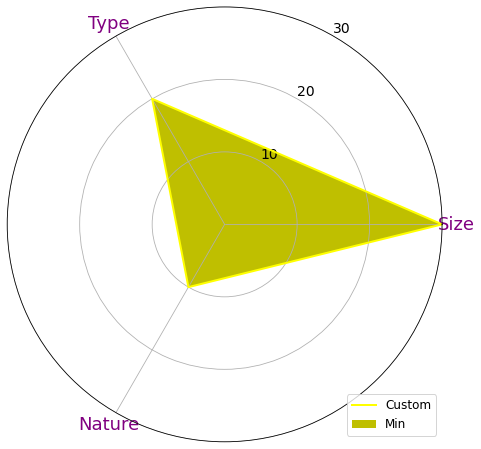

In [ ]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
from math import pi
 
# Set data
df = pd.DataFrame({
'Data': ['Custom','Min','Max'],
'Size': [30,10,30],
'Type': [20,10,30],
'Nature': [10,10,30]
})
 
# number of variable
categories=list(df)[1:]
N = len(categories)
labels=['Custom','Min','Max']

# We are going to plot the first line of the data frame.
# But we need to repeat the first value to close the circular graph:
values=df.loc[0].drop('Data').values.flatten().tolist()
values += values[:1]
values
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111, polar=True)
 
# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories, color='purple', size=18)
# Draw ylabels
ax.set_rlabel_position(60)
plt.yticks([10,20,30],color="black", size=14)#{"easy",'medium','hard}
plt.ylim(0,30)
 
# Plot data
ax.plot(angles, values, linewidth=2, linestyle='solid',color='yellow')
# Fill area
ax.fill(angles, values, 'y', alpha=1)
plt.legend(labels,loc=4,fontsize="12")
# Show the graph
plt.show()

In [ ]:
import plotly.graph_objects as go

categories = ['Size', 'Type', 'Nature']

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=[3, 2, 1],
      theta=categories,
      fill='toself',
      fillcolor='rgba(255, 0, 0, 0.5)',
      name='Custom'
))
fig.add_trace(go.Scatterpolar(
      r=[1, 1, 1],
      theta=categories,
      #fill='toself',
     # fillcolor='rgba(0, 255, 0, 0.5)',
      name='Min'
))
fig.add_trace(go.Scatterpolar(
      r=[3, 3, 3],
      theta=categories,
      #fill='toself',
      #fillcolor='rgba(0, 0, 255, 0.5)',
      name='Max'
))

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 3],
            tickmode='linear',
            tick0=0,
            dtick=1
        )
    ),
    showlegend=True
)

fig.show()


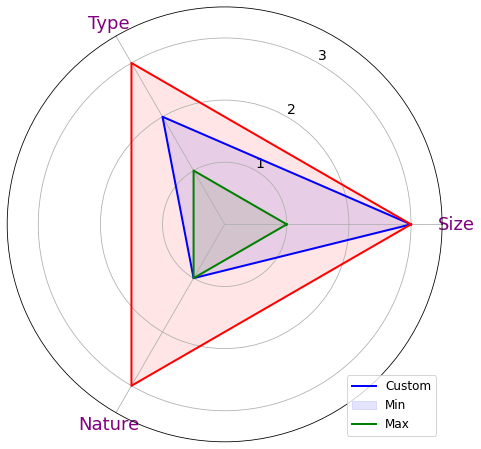

In [ ]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
from math import pi

# Set data
df = pd.DataFrame({
    'Data': ['Custom', 'Min', 'Max'],
    'Size': [3, 1, 3],
    'Type': [2, 1, 3],
    'Nature': [1, 1, 3]
})

# number of variable
categories = list(df)[1:]
N = len(categories)
labels = list(df['Data'])

# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Initialise the spider plot
fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

# Increase diameter of innermost radial axis
ax.set_ylim(0, 3.5)

# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories, color='purple', size=18)

# Draw ylabels
ax.set_rlabel_position(60)
plt.yticks([1, 2, 3], color="black", size=14)
colors_fill=['blue','green','red']
# Plot data
for i in range(len(df)):
    values = df.iloc[i, 1:].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid',color=colors_fill[i])
    ax.fill(angles, values, alpha=0.1,color=colors_fill[i])

plt.legend(labels, loc=4, fontsize="12")

# Show the graph
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from math import pi

# Set data
df = pd.DataFrame({
    'Data': ['Your choice', 'Min', 'Max'],
    'Size': [3, 1, 3],
    'Type': [1, 1, 3],
    'Nature': [1, 1, 3],
    'Source':[1,1,3]
})

# number of variable
categories = list(df)[1:]
N = len(categories)
labels = list(df['Data'])

# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Define a colormap
cmap = plt.get_cmap('Set1')

# Initialise the spider plot
fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

# Increase diameter of innermost radial axis
ax.set_ylim(0, 3)

# Assign different colors to radial axes
for i, tick in enumerate(ax.yaxis.get_major_ticks()):
    tick.label1.set_color('gray')
    tick.label1.set_fontsize(14)

# Set the increment of the radial axis to 1
ax.set_yticks(np.arange(1, 3, 1))

# Draw one axe per variable + add labels
plt.xticks(angles[0:2], categories, color='purple', size=18)
plt.xticks(angles[2:-1],categories,color='red',size=22)

# Draw ylabels
ax.set_rlabel_position(60)
plt.yticks([1, 2, 3], color="black", size=14)

# Plot data
for i in range(len(df)):
    values = df.iloc[i, 1:].values.flatten().tolist()
    values += values[:1]
    color = cmap(i)
    ax.plot(angles, values, linewidth=2, linestyle='solid', color='gray')
    ax.fill(angles, values, color=color, alpha=0.2)

# Add legend with heading
handles = [plt.Rectangle((0,0),1,1, color=cmap(i), alpha=0.2) for i in range(len(df))]
legend = plt.legend(handles, labels, loc=(1.1,-.001), fontsize="12")
legend.set_title("Data Overview", prop={"size":15, "weight":"bold"})
plt.title("Degree Of Difficulty: Moderate",loc='center',size=25)
plt.text(0.5,3.75, " Size: Bigdata \n Type: Structured \n Nature: Causal \n Data Source: Database", fontsize=16, bbox=dict(facecolor='red', alpha=0.3))
plt.text(1,3.75, "  LEVEL1  \n 1: Easy \n 2: Moderate \n 3: Complex ", fontsize=16, bbox=dict(facecolor='red', alpha=0.3))
# Show the graph
plt.show()
plt.savefig('radar_alpha.jpg',dpi='figure',format='jpg')

In [ ]:
import plotly.graph_objects as go

# Define the nodes
node_labels = ['Starting Block', 'Block 1', 'Block 2', 'Block 3', 'Block 4',
               'Intermediate Block 1', 'Intermediate Block 2', 'Intermediate Block 3', 'Intermediate Block 4', 'Final Node']

# Define the links
link_source = [0, 0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8]
link_target = [1, 2, 3, 4, 5, 6, 7, 8, 9, 9, 9, 9]
link_value = [100, 50, 30, 20, 75, 50, 30, 25, 20, 75, 50, 20]

# Define the Sankey trace
fig = go.Figure(data=[go.Sankey(
    node=dict(
        label=node_labels,
        pad=15,
        thickness=25,
        color='blue',
        line=dict(width=0)
    ),
    link=dict(
        source=link_source,
        target=link_target,
        value=[15,15,15,15,15,15,15,15,15,15,15,15]
    )
)])

# Update the layout
fig.update_layout(
    title="Sankey Flow Chart",
    font=dict(size=12, color='black'),
    height=800,
    width=1000
)

# Update the node size
# for node in fig.data[0]['node']:
#     if node['label'] in ['Intermediate Block 1', 'Intermediate Block 2', 'Intermediate Block 3', 'Intermediate Block 4']:
#         node['thickness'] = 20

# Show the figure
fig.show()


In [ ]:
import plotly.graph_objects as go

# Define the nodes of the Sankey diagram
nodes = go.Sankey.Node(
    label=['Node A', 'Node B', 'Node C', 'Node D', 'Node E', 'Node F'],
    pad=10,
    thickness=20
)

# Define the links between the nodes
links = go.Sankey.Link(
    source=[0, 0, 1, 1, 2, 2, 3, 3, 4, 4],
    target=[2, 3, 2, 3, 4, 5, 4, 5, 3, 5],
    value=[8, 4, 2, 6, 3, 5, 1, 7, 3, 2],
    thickness=[0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5],  # Set the thickness of the links
)

# Create the Sankey diagram
fig = go.Figure(data=[go.Sankey(node=nodes, link=links)])

# Show the diagram
fig.show()


In [ ]:
from tensorflow.keras.layers import Dense,MultiHeadAttention,LayerNormalization,LSTM,Bidirectional,Input,Embedding,Dropout,Concatenate
from tensorflow.keras import Model

In [ ]:
# model=Sequential()
# model.add(Input(shape=(1992,)))
# model.add(Embedding(input_dim=size_of_vocabulary,output_dim=100,weights=[embedding_matrix],input_length=max_len2,trainable=True))
# model.add(Dense(1,activation='softmax'))

# model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
# model.summary()

In [ ]:
# Encoder 
encoder_input = Input(shape=(1992,))
encoder_embed = Embedding(input_dim=size_of_vocabulary, output_dim=100, weights=[embedding_matrix],input_length=max_len2)(encoder_input)

# Attention layer
encoder_attention = MultiHeadAttention(num_heads=3, key_dim=2)
encoder_outputs = encoder_attention(encoder_embed, encoder_embed, encoder_embed)

# LSTM layer
encoder_lstm = Bidirectional(LSTM(50, activation='gelu', return_sequences=True, return_state=True))
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_lstm(encoder_outputs)
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
encoder_outputs = LayerNormalization()(encoder_embed + encoder_outputs)
encoder_states = [state_h, state_c]

# Feedforward layers
encoder_ff = Dense(units=64, activation='gelu')(encoder_outputs)
encoder_ff = Dense(units=1, activation='softmax')(encoder_ff)


# Decoder
decoder_input = Input(shape=(1992,))
decoder_embed = Embedding(input_dim=size_of_vocabulary, output_dim=100, input_length=max_len2)(decoder_input)

# Attention layer
decoder_attention = MultiHeadAttention(num_heads=3, key_dim=2)
decoder_outputs = decoder_attention(decoder_embed, encoder_outputs, encoder_outputs)
decoder_outputs = LayerNormalization()(decoder_embed + decoder_outputs)

# LSTM layer
decoder_lstm = LSTM(units=100, activation='gelu', return_sequences=True, return_state=True)
decoder_outputs, _, _  = decoder_lstm(decoder_outputs, initial_state=encoder_states)

# Feedforward layers
decoder_ff = Dense(units=64, activation='gelu')(decoder_outputs)
decoder_ff = Dense(units=1, activation='softmax')(decoder_ff)

In [ ]:
#Model
model=Model(inputs=[encoder_input,decoder_input],outputs=decoder_ff)

print(model.summary())

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1992)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1992, 100)    1493800     ['input_1[0][0]']                
                                                                                                  
 multi_head_attention (MultiHea  (None, 1992, 100)   2518        ['embedding[0][0]',              
 dAttention)                                                      'embedding[0][0]',              
                                                                  'embedding[0][0]']              
                                                                                              

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
# embedding_matrix_new = np.zeros((size_of_vocabulary, 100))

# for word in w2v_my:
#   if embeddings[index] is not None:
#     embedding_matrix_new[index] = w2v_my[word]

In [ ]:
model.fit(x=[tensor1,tensor2],y=tensor2,validation_data=([tensor1_test,tensor2_test],tensor2_test),epochs=5,batch_size=15)

Epoch 1/5


/usr/local/lib/python3.9/dist-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


 55/198 [=======>......................] - ETA: 1:58:59 - loss: 636597.4375 - acc: 0.0028

KeyboardInterrupt: ignored

In [ ]:
curl -X GET \
     "https://datasets-server.huggingface.co/first-rows?dataset=wiki_lingua&config=arabic&split=train"

In [ ]:
data=load_dataset('wikihow','sep')

In [ ]:
data

DatasetDict({
    train: Dataset({
        features: ['url', 'article'],
        num_rows: 57945
    })
})

In [ ]:
data['train']['article'][0]

In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 49.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 34.4 MB/s eta 0:00:00


In [ ]:
from transformers import AutoTokenizer,AutoModelForCausalLM

In [ ]:
from transformers import pipeline

summarizer = pipeline("summarization", model="lidiya/bart-large-xsum-samsum")


In [9]:
import pandas as pd

data=pd.read_excel('/content/web_scraped_data.xlsx')

In [10]:
df=pd.DataFrame(data,columns=['text','summary'])

In [11]:
df.head()

,text,summary
0,Streamlining Machine Learning Workflows with M...,MLOps (short for â€œmachine learning operation...
1,Explaining MLOps using MLflow Tool - Analytics...,Since managing the lifecycle of ML using MLOps...
2,Saving the Titanic Using Azure AutoML! - Analy...,How does this benefit you?All Azure AutoML doe...
3,Amazon Sagemaker Tool for MLOps - Analytics Vi...,Managing a complete lifecycle on a scale using...
4,Explainable Artificial Intelligence (XAI) for ...,"Guys, We have discussed the XAI at a high leve..."


In [12]:
df.drop('text',axis=1,inplace=True)

In [13]:
df.dropna(inplace=True)

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

In [17]:
import re

def clean(dataframe):
  x=[]
  for i in dataframe['summary']:
    y=re.sub('^[A-Za-z]',"",i)
    y=re.sub(' Duration: Dec 12',"",y)
    y = y.replace('  ', '')
  x.append(y)
  return(x)

In [23]:
df['summary'][1]

'Since managing the lifecycle of ML using MLOps can be challenging, every tool that can help assist and ease the pain becomes very useful. MLOps becomes achievable using the features of tools such as MLflow. With edge-cutting features in model and data management and providing a very large range of ways to develop models that perform very well in meeting MLOps standards, MLflow is another tool to look out for. The biggest achievement with MLflow is data and model management.Key Takeaways;As you may have known, a perfect approach to learning something is via tools. Tools provide a hands-on understanding of concepts where we saw MLOps.MLOps can be seen as a set of guidelines that machine learning (ML) experts follow to hasten the deployment of ML models in real projects and enhance the overall integration of various project pipeline operations.There are three key things MLOps bring to the table; there are automation, continuous deployment, and monitoringMLOps tools help organizations app

In [27]:
y=re.sub('^[A-Za-z]',"",df['summary'][1])
y=re.sub(' Duration: Dec 12',"",y)
y=y.replace('The media shown in this article is not owned by Analytics Vidhya and is used at the Authorâ€™s discretion', '')
y=y.replace('Dec 12 <','')
y=y.replace('Thanks for Reading!.','')
y.replace('If you liked this blog, consider following me on Analytics Vidhya, Medium, GitHub, andÂ\xa0LinkedIn.','')

'ince managing the lifecycle of ML using MLOps can be challenging, every tool that can help assist and ease the pain becomes very useful. MLOps becomes achievable using the features of tools such as MLflow. With edge-cutting features in model and data management and providing a very large range of ways to develop models that perform very well in meeting MLOps standards, MLflow is another tool to look out for. The biggest achievement with MLflow is data and model management.Key Takeaways;As you may have known, a perfect approach to learning something is via tools. Tools provide a hands-on understanding of concepts where we saw MLOps.MLOps can be seen as a set of guidelines that machine learning (ML) experts follow to hasten the deployment of ML models in real projects and enhance the overall integration of various project pipeline operations.There are three key things MLOps bring to the table; there are automation, continuous deployment, and monitoringMLOps tools help organizations appl

In [ ]:
tokenizer=Tokenizer()

tokenizer.fit_on_texts(df['summary'])

In [ ]:
size_of_vocabulary = len(tokenizer.word_index) + 1
size_of_vocabulary

22215

In [ ]:
cleaned=clean(df)

In [ ]:
cleaned[0]

'LOps (short for â€œmachine learning operationsâ€\x9d) is a set of practices and tools that enable organizations to streamline and optimize their machine learning (ML) workflows. This includes everything from the development and training of ML models to their deployment and management in production. The goal of MLOps is to improve the collaboration, efficiency, and reliability of ML pipelines, resulting in faster time to value and more successful ML deployments. MLOps builds on the principles of DevOps, which is a set of practices and tools for improving collaboration and efficiency in software development. Like DevOps, MLOps emphasizes automation, collaboration, and continuous improvement.MLOps has improved the industry by streamlining and optimizing machine learning workflows.MLOps practices and techniques, such as continuous integration and delivery, infrastructure as code, and experiment management can improve collaboration, efficiency, and reliability of ML pipelines.This leads to

In [ ]:
re.sub('(/r+)',"",df['summary'][0])

'MLOps (short for â€œmachine learning operationsâ€\x9d) is a set of practices and tools that enable organizations to streamline and optimize their machine learning (ML) workflows. This includes everything from the development and training of ML models to their deployment and management in production. The goal of MLOps is to improve the collaboration, efficiency, and reliability of ML pipelines, resulting in faster time to value and more successful ML deployments. MLOps builds on the principles of DevOps, which is a set of practices and tools for improving collaboration and efficiency in software development. Like DevOps, MLOps emphasizes automation, collaboration, and continuous improvement.MLOps has improved the industry by streamlining and optimizing machine learning workflows.MLOps practices and techniques, such as continuous integration and delivery, infrastructure as code, and experiment management can improve collaboration, efficiency, and reliability of ML pipelines.This leads t

In [ ]:
x,y=[],[]
a,b=[],[]

for i in df['summary'][0]:
  if(i=='('):
    a.append(df['summary'][0].find('('))
  if(i==')'):
    b.append(df['summary'][0].find(')'))
x.append(a)
y.append(b)

In [ ]:
x

[[6, 6, 6, 6]]

In [ ]:
y.replace('Thanks for Reading!','')

'MLOps   is a set of practices and tools that enable organizations to streamline and optimize their machine learning (ML) workflows. This includes everything from the development and training of ML models to their deployment and management in production. The goal of MLOps is to improve the collaboration, efficiency, and reliability of ML pipelines, resulting in faster time to value and more successful ML deployments. MLOps builds on the principles of DevOps, which is a set of practices and tools for improving collaboration and efficiency in software development. Like DevOps, MLOps emphasizes automation, collaboration, and continuous improvement.MLOps has improved the industry by streamlining and optimizing machine learning workflows.MLOps practices and techniques, such as continuous integration and delivery, infrastructure as code, and experiment management can improve collaboration, efficiency, and reliability of ML pipelines.This leads to faster time to value and more successful ML d